In [36]:
import sys
import warnings
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from tqdm import tqdm
import os
import random

if not sys.warnoptions:
    warnings.simplefilter('ignore')
tf.compat.v1.disable_eager_execution()
tf.random.set_random_seed(1234)

In [37]:
# Load and prepare data
df = pd.read_csv(r'C:\Users\HP\Downloads\vn100_prices.csv', parse_dates=['TradingDate'])
columns_to_choose = [col for col in df.columns if col != 'TradingDate']

# Choose 5 random columns
random_columns = random.sample(columns_to_choose, 5)
random_columns

['EIB', 'KDH', 'DBC', 'REE', 'VRE']

In [38]:
# Parameters
simulation_size = 1
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 5 # set to 150 for better results
dropout_rate = 0.8
test_size = 30
learning_rate = 0.01
attention_units = 128
results = []

Simulation 1 for column: EIB


train loop: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s, acc=85.4, cost=0.061] 


Simulation 1 for column: KDH


train loop: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s, acc=91.7, cost=0.0194]


Simulation 1 for column: DBC


train loop: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s, acc=90.2, cost=0.0294]


Simulation 1 for column: REE


train loop: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s, acc=87.9, cost=0.0421]


Simulation 1 for column: VRE


train loop: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s, acc=84.6, cost=0.0631]


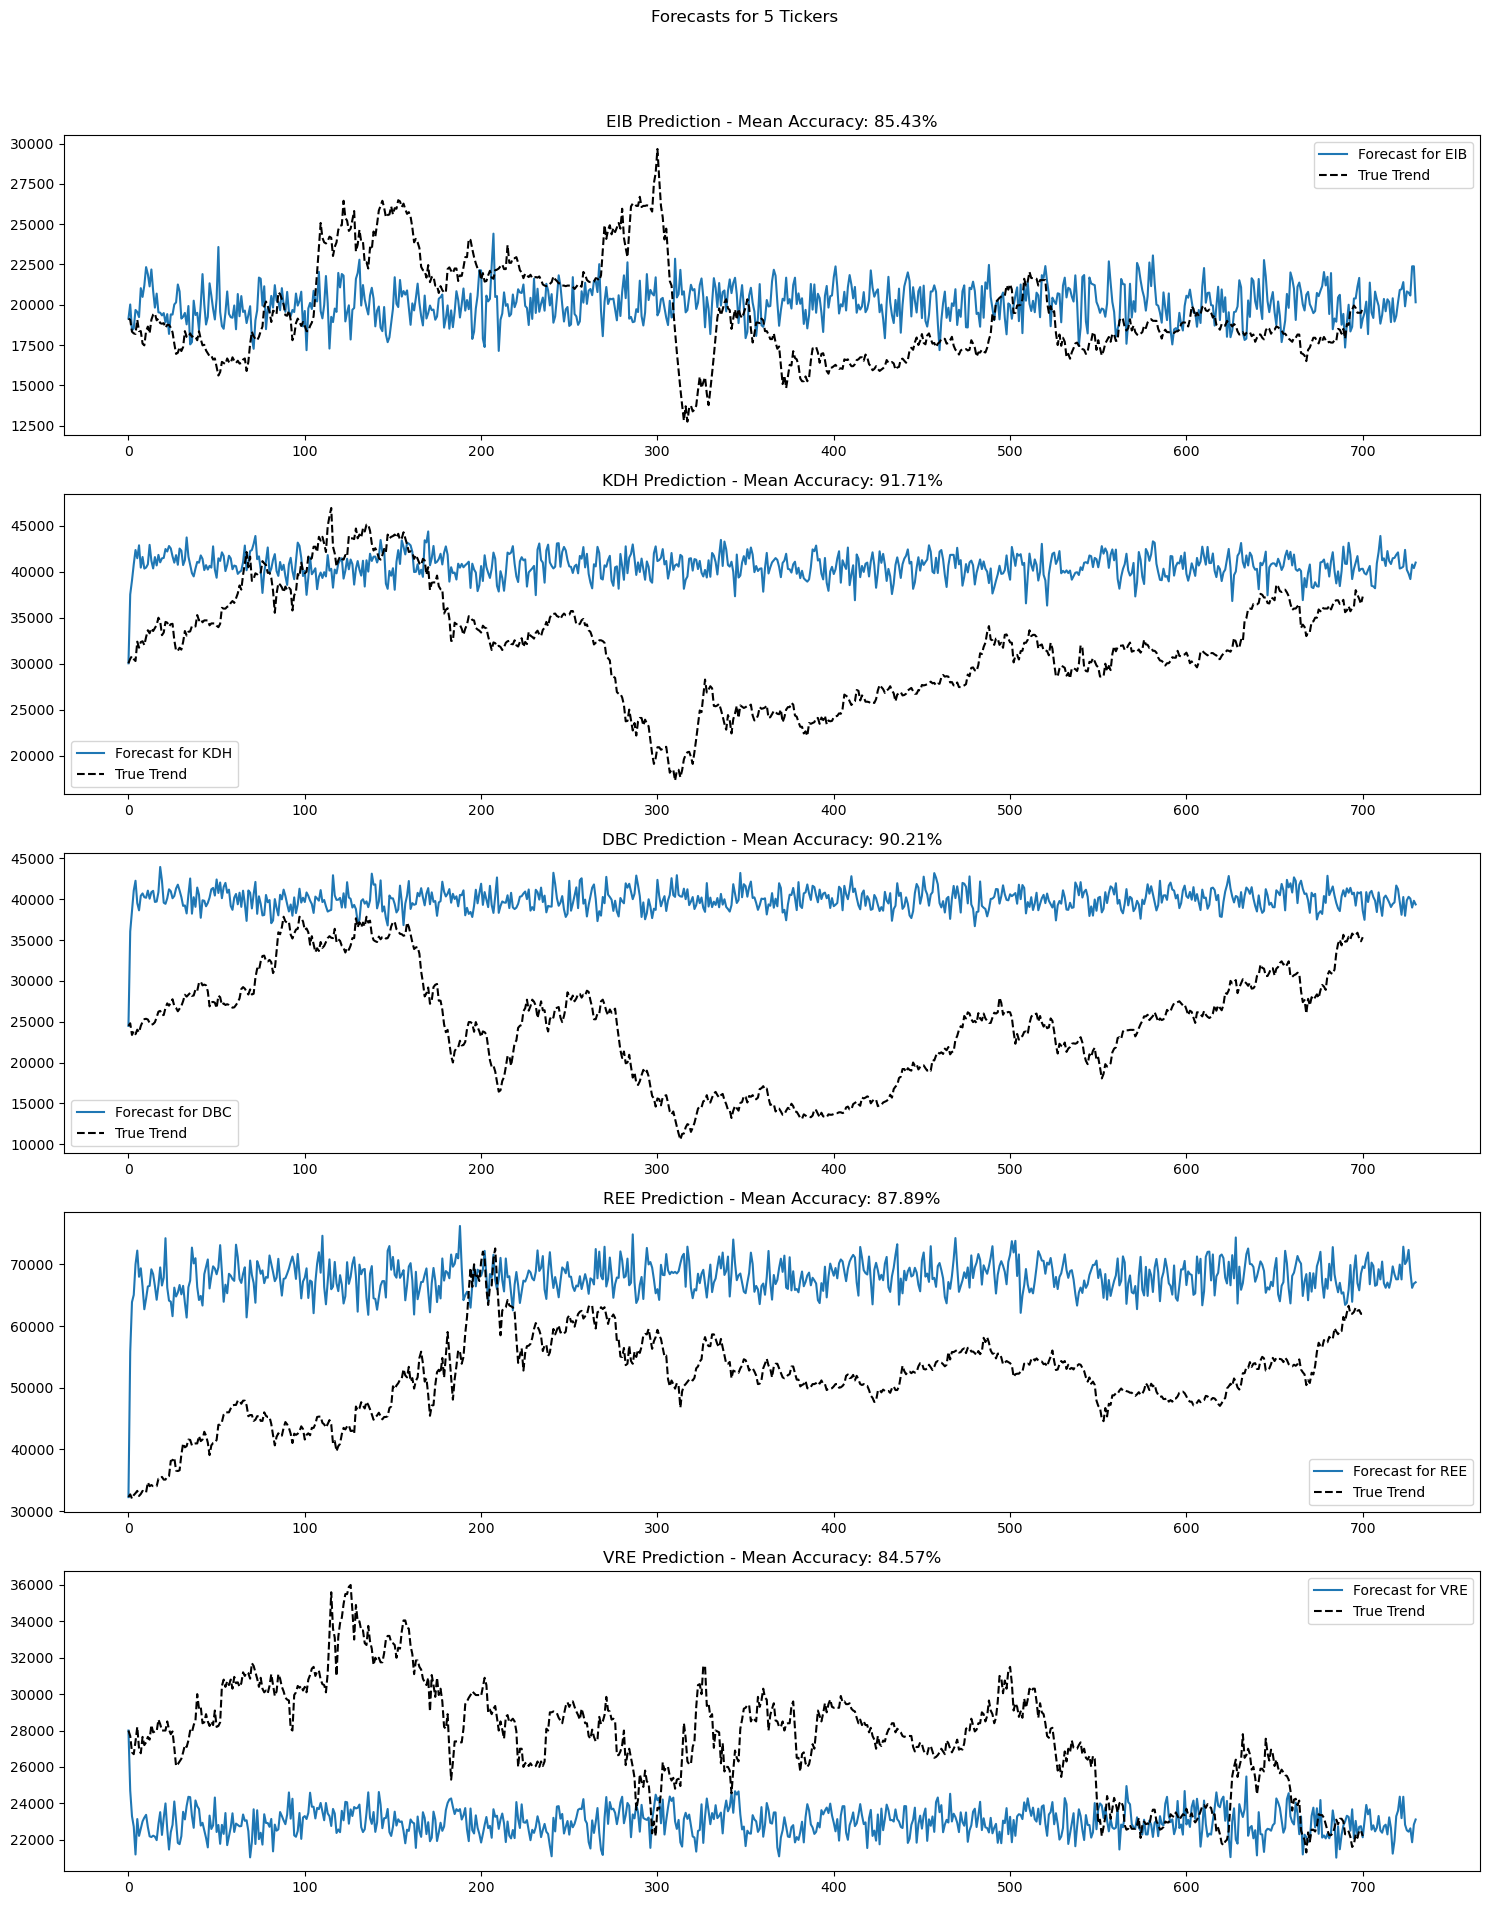

In [39]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 20))
fig.suptitle('Forecasts for 5 Tickers')

for idx, column in enumerate(random_columns):
    new_df = df[[column]]
    minmax = MinMaxScaler().fit(new_df.astype('float32'))
    df_log = minmax.transform(new_df.astype('float32'))
    df_log = pd.DataFrame(df_log)
    df_train = df_log

    def position_encoding(inputs):
        T = tf.shape(inputs)[1]  # Get the number of time steps dynamically
        repr_dim = inputs.get_shape()[-1]  # Get the static shape if available
        repr_dim = tf.compat.v1.dimension_value(repr_dim)  # For compatibility with newer TensorFlow versions
        pos = tf.reshape(tf.range(0.0, tf.cast(T, dtype=tf.float32), dtype=tf.float32), [-1, 1])
        i = np.arange(0, repr_dim, 2, np.float32)
        denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
        enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
        return tf.tile(enc, [tf.shape(inputs)[0], 1, 1])

    def layer_norm(inputs, epsilon=1e-8):
        mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
        normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
        params_shape = inputs.get_shape()[-1:]
        gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
        beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
        return gamma * normalized + beta

    def cnn_block(x, dilation_rate, pad_sz, hidden_dim, kernel_size):
        x = layer_norm(x)
        pad = tf.zeros([tf.shape(x)[0], pad_sz, hidden_dim])
        x =  tf.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
                            filters = hidden_dim,
                            kernel_size = kernel_size,
                            dilation_rate = dilation_rate)
        x = x[:, :-pad_sz, :]
        x = tf.nn.relu(x)
        return x

    class Model:
        def __init__(
            self,
            learning_rate,
            num_layers,
            size,
            size_layer,
            output_size,
            kernel_size = 3,
            n_attn_heads = 16,
            dropout = 0.9,
        ):
            self.X = tf.placeholder(tf.float32, (None, None, size))
            self.Y = tf.placeholder(tf.float32, (None, output_size))

            encoder_embedded = tf.layers.dense(self.X, size_layer)
            encoder_embedded += position_encoding(encoder_embedded)
            
            e = tf.identity(encoder_embedded)
            for i in range(num_layers): 
                dilation_rate = 2 ** i
                pad_sz = (kernel_size - 1) * dilation_rate 
                with tf.variable_scope('block_%d'%i):
                    encoder_embedded += cnn_block(encoder_embedded, dilation_rate, 
                                                pad_sz, size_layer, kernel_size)
                    
            encoder_output, output_memory = encoder_embedded, encoder_embedded + e
            g = tf.identity(encoder_embedded)

            for i in range(num_layers):
                dilation_rate = 2 ** i
                pad_sz = (kernel_size - 1) * dilation_rate
                with tf.variable_scope('decode_%d'%i):
                    attn_res = h = cnn_block(encoder_embedded, dilation_rate, 
                                            pad_sz, size_layer, kernel_size)

                C = []
                for j in range(n_attn_heads):
                    h_ = tf.layers.dense(h, size_layer // n_attn_heads)
                    g_ = tf.layers.dense(g, size_layer // n_attn_heads)
                    zu_ = tf.layers.dense(
                        encoder_output, size_layer // n_attn_heads
                    )
                    ze_ = tf.layers.dense(output_memory, size_layer // n_attn_heads)

                    d = tf.layers.dense(h_, size_layer // n_attn_heads) + g_
                    dz = tf.matmul(d, tf.transpose(zu_, [0, 2, 1]))
                    a = tf.nn.softmax(dz)
                    c_ = tf.matmul(a, ze_)
                    C.append(c_)

                c = tf.concat(C, 2)
                h = tf.layers.dense(attn_res + c, size_layer)
                h = tf.nn.dropout(h, keep_prob = dropout)
                encoder_embedded += h

            encoder_embedded = tf.sigmoid(encoder_embedded[-1])
            self.logits = tf.layers.dense(encoder_embedded, output_size)
            self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
                self.cost
            )
            
    def calculate_accuracy(real, predict):
        real = np.array(real) + 1
        predict = np.array(predict) + 1
        percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
        return percentage * 100

    def anchor(signal, weight):
        buffer = []
        last = signal[0]
        for i in signal:
            smoothed_val = last * weight + (1 - weight) * i
            buffer.append(smoothed_val)
            last = smoothed_val
        return buffer
    
    def forecast():
        tf.reset_default_graph()
        modelnn = Model(
            learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], 
            dropout = dropout_rate
        )
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())
        date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

        pbar = tqdm(range(epoch), desc = 'train loop')
        for i in pbar:
            init_value = np.zeros((1, num_layers * 2 * size_layer))
            total_loss, total_acc = [], []
            for k in range(0, df_train.shape[0] - 1, timestamp):
                index = min(k + timestamp, df_train.shape[0] - 1)
                batch_x = np.expand_dims(
                    df_train.iloc[k : index, :].values, axis = 0
                )
                batch_y = df_train.iloc[k + 1 : index + 1, :].values
                logits, _, loss = sess.run(
                    [modelnn.logits, modelnn.optimizer, modelnn.cost],
                    feed_dict = {modelnn.X: batch_x, modelnn.Y: batch_y},
                )        
                total_loss.append(loss)
                total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
            pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
        
        future_day = test_size

        output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
        output_predict[0] = df_train.iloc[0]
        upper_b = (df_train.shape[0] // timestamp) * timestamp

        for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
            out_logits = sess.run(
                modelnn.logits,
                feed_dict = {
                    modelnn.X: np.expand_dims(
                        df_train.iloc[k : k + timestamp], axis = 0
                    )
                },
            )
            output_predict[k + 1 : k + timestamp + 1] = out_logits

        if upper_b != df_train.shape[0]:
            out_logits = sess.run(
                modelnn.logits,
                feed_dict = {
                    modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0)
                },
            )
            output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
            future_day -= 1
            date_ori.append(date_ori[-1] + timedelta(days = 1))
        
        for i in range(future_day):
            o = output_predict[-future_day - timestamp + i:-future_day + i]
            out_logits = sess.run(
                modelnn.logits,
                feed_dict = {
                    modelnn.X: np.expand_dims(o, axis = 0)
                },
            )
            output_predict[-future_day + i] = out_logits[-1]
            date_ori.append(date_ori[-1] + timedelta(days = 1))

        output_predict = minmax.inverse_transform(output_predict)
        deep_future = anchor(output_predict[:, 0], 0.3)
        mean_accuracy = np.mean(total_acc)
        
        return deep_future, mean_accuracy
    
    for i in range(simulation_size):
        print(f'Simulation {i+1} for column: {column}')
        forecast_results, accuracy = forecast()
        results.append(forecast_results)

    # Plot results for each column
    axes[idx].plot(forecast_results, label=f'Forecast for {column}')
    axes[idx].plot(new_df.values, label='True Trend', color='black', linestyle='--')
    axes[idx].legend()
    axes[idx].set_title(f'{column} Prediction - Mean Accuracy: {accuracy:.2f}%')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()